# Evaluation of Figure 2

In this notebook, the data for Figure 2 is prepared. Note, that due to known issues in the umap-learn package, the plots are not 100% reproducable over all machines. However the overall structure will be preserved.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import anndata

In [2]:
import sys
sys.path.append('../..')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

In [3]:
def load_model(adata, model, donor):
    path_model = f'saved_models/journal/10x/full/donor_{donor}/{model}_'
    path_model += f'donor_{donor}_full.pt'
    model = utils.load_model(adata, path_model)
    adata.obs['set'] = 'train'
    return model
    

In [4]:
def load_10x_data(donor):
    adata = utils.load_data('10x')
    adata = adata[adata.obs['donor'] == f'donor_{donor}']
    adata = adata[adata.obs['binding_name'].isin(const.donor_2_high_count_antigens)]
    return adata

## Loading

In [5]:
donor = 2

data = load_10x_data(donor)
models = {model_name: load_model(data, model_name, donor) for model_name in ['moe', 'rna', 'tcr']}

Trying to set attribute `.obs` of view, copying.


## Adding binding list

In [34]:
path_binding = '../../data/10x_CD8TC/' + f'patient_{donor}/vdj_v1_hs_aggregated_donor{donor}_binarized_matrix.csv'
binarized_matrix = pd.read_csv(path_binding, sep=',', header=0, index_col=0)
binarized_matrix.index.name = None
cols_binder_counts = data.obs['binding_name'].unique().tolist()
cols_binder_counts = ['_'.join(el.split('_')[:-1]) for el in cols_binder_counts]
binarized_matrix = binarized_matrix[cols_binder_counts]
binarized_matrix.index = binarized_matrix.index + f'-donor_{donor}'
binarized_matrix.head()

,A0201_GILGFVFTL_Flu-MP_Influenza,B0801_RAKFKQLL_BZLF1_EBV,A0301_KLGGALQAK_IE-1_CMV,A0201_GLCTLVAML_BMLF1_EBV,A1101_AVFDRKSDAK_EBNA-3B_EBV
AAACCTGAGAAACCTA-30-donor_2,0.0,61.0,4.0,0.0,1.0
AAACCTGAGAACTCGG-39-donor_2,0.0,0.0,3.0,0.0,2.0
AAACCTGAGAAGGGTA-9-donor_2,0.0,20.0,1.0,1.0,1.0
AAACCTGAGACACTAA-40-donor_2,0.0,0.0,0.0,0.0,1.0
AAACCTGAGACGCTTT-11-donor_2,0.0,79.0,6.0,0.0,0.0


In [43]:
binarized_matrix = binarized_matrix.loc[data.obs.index]
data.obsm['binding_counts'] = binarized_matrix.values

## Latent and UMAPs

In [50]:
moe_model = models['moe']
latent_moe = moe_model.get_latent(data, metadata=['binding_name', 'clonotype'], return_mean=True)
latent_moe.obsm['binding_counts'] = data.obsm['binding_counts']

In [48]:
rna_model = models['rna']
latent_rna = rna_model.get_latent(data, metadata=['binding_name', 'clonotype'])
latent_rna.obsm['binding_counts'] = data.obsm['binding_counts']

In [49]:
tcr_model = models['tcr']
latent_tcr = tcr_model.get_latent(data, metadata=['binding_name', 'clonotype'])
latent_tcr.obsm['binding_counts'] = data.obsm['binding_counts']

In [58]:
latents = {
    'moe': latent_moe,
    'rna': latent_rna,
    'tcr': latent_tcr,
}

### Predict counts

In [101]:
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm

In [108]:
k = 10
kf = KFold(n_splits=k, shuffle=True) 

def results_cross_validation(X, y):
    #X = X.reshape(-1,1)
    scores = []
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        mse = mean_squared_error(y_true = y_test, y_pred = pred_values)
        scores.append(mse)
    return scores

results_cross_validation(adata.X, adata.obsm['binding_counts'][:, 0])

[1370.9750003089898,
 1691.285115915358,
 1532.1344811064737,
 2000.5319386518408,
 1832.1084724406878,
 1535.893880828379,
 82826.40627208038,
 1802.5474918040106,
 1534.66461317579,
 1581.2757850926344]

In [109]:
scores = []
models = []
folds = []
binders = []

n_binders = adata.obsm['binding_counts'].shape[1]

for space, adata in latents.items():
    for i in range(n_binders):
        scores_space = results_cross_validation(adata.X, adata.obsm['binding_counts'][:, i])
        models += [space] * k
        folds += list(range(k))
        scores += scores_space
        binders += [cols_binder_counts[i]] * k

results = pd.DataFrame(data={
    'model': models,
    'fold': folds,
    'binder': binders,
    'MSE': scores 
})
results

,model,fold,binder,MSE
0,moe,0,A0201_GILGFVFTL_Flu-MP_Influenza,2129.443615
1,moe,1,A0201_GILGFVFTL_Flu-MP_Influenza,81278.302584
2,moe,2,A0201_GILGFVFTL_Flu-MP_Influenza,2258.230519
3,moe,3,A0201_GILGFVFTL_Flu-MP_Influenza,1856.836974
4,moe,4,A0201_GILGFVFTL_Flu-MP_Influenza,1738.464912
...,...,...,...,...
145,tcr,5,A1101_AVFDRKSDAK_EBNA-3B_EBV,165.766745
146,tcr,6,A1101_AVFDRKSDAK_EBNA-3B_EBV,80.341031
147,tcr,7,A1101_AVFDRKSDAK_EBNA-3B_EBV,113.547915
148,tcr,8,A1101_AVFDRKSDAK_EBNA-3B_EBV,100.426394


In [110]:
results.groupby(['model', 'binder'])['MSE'].mean()

model  binder                          
moe    A0201_GILGFVFTL_Flu-MP_Influenza     9966.515844
       A0201_GLCTLVAML_BMLF1_EBV             144.734281
       A0301_KLGGALQAK_IE-1_CMV               69.962236
       A1101_AVFDRKSDAK_EBNA-3B_EBV           75.117096
       B0801_RAKFKQLL_BZLF1_EBV             2532.101674
rna    A0201_GILGFVFTL_Flu-MP_Influenza    10046.469967
       A0201_GLCTLVAML_BMLF1_EBV             160.881873
       A0301_KLGGALQAK_IE-1_CMV               72.304496
       A1101_AVFDRKSDAK_EBNA-3B_EBV           76.006052
       B0801_RAKFKQLL_BZLF1_EBV             2340.759557
tcr    A0201_GILGFVFTL_Flu-MP_Influenza     9772.509502
       A0201_GLCTLVAML_BMLF1_EBV             142.581793
       A0301_KLGGALQAK_IE-1_CMV               67.861072
       A1101_AVFDRKSDAK_EBNA-3B_EBV           74.952359
       B0801_RAKFKQLL_BZLF1_EBV             2240.968185
Name: MSE, dtype: float64

<AxesSubplot:xlabel='model', ylabel='MSE'>

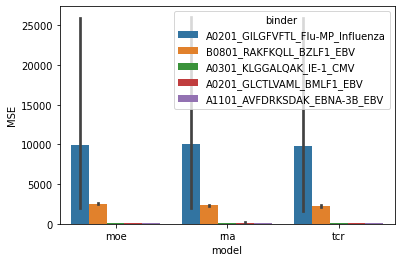

In [111]:
sb.barplot(data=results, y='MSE', x='model', hue='binder')

In [112]:
data.obs['binding_name'].value_counts()

B0801_RAKFKQLL_BZLF1_EBV_binder            16410
A0201_GILGFVFTL_Flu-MP_Influenza_binder     5412
A0301_KLGGALQAK_IE-1_CMV_binder             3587
A0201_GLCTLVAML_BMLF1_EBV_binder            1224
A1101_AVFDRKSDAK_EBNA-3B_EBV_binder          362
Name: binding_name, dtype: int64

In [113]:
cols_binder_counts

['A0201_GILGFVFTL_Flu-MP_Influenza',
 'B0801_RAKFKQLL_BZLF1_EBV',
 'A0301_KLGGALQAK_IE-1_CMV',
 'A0201_GLCTLVAML_BMLF1_EBV',
 'A1101_AVFDRKSDAK_EBNA-3B_EBV']

In [114]:
data.obsm['binding_counts'].max(axis=0)

array([14899.,   582.,   123.,   337.,   557.])